# Load in previously trained Logistic Regression model and classify unknown samples

In [276]:
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import numpy as np
#from itertools import combinations
import sys
import importlib

sys.path.append('../../scripts/')
# Contains special functions used in the script 
import GeochemFunctions as geofctns
importlib.reload(geofctns)

import GeochemPlotting as geoplots
importlib.reload(geoplots)

!pwd

/Users/leif/gitrepos/learngeochem/notebooks/Hampton_CRB


In [277]:

###Classify at formation level
# filename = 'CRB_Formation_trainedon_100pct.pkl'
# datalabelname = 'CRB_Formation_labels.pkl'
# classlabels = 'FormationLookupTable.pkl'

####Classify at member
filename = 'CRB_Member_trainedon_100pct_all_members.pkl'

datalabelname = 'CRB_Member_labels_all_members.pkl'

classlabels = 'MemberLookupTable.pkl'

featurelabels = 'TrainingDataFeatures.pkl'

# load the model from disk
CRB_model = pickle.load(open(filename, 'rb'))

CRB_feature_labels = pickle.load(open(datalabelname, 'rb'))
CRB_class_labels = pickle.load(open(classlabels, 'rb'))

trainingdata_labels = pickle.load(open(featurelabels, 'rb'))
print(trainingdata_labels)
print(CRB_class_labels)
CRB_feature_labels

['SiO2' 'TiO2' 'Al2O3' 'MnO' 'MgO' 'CaO' 'Na2O' 'K2O' 'P2O5' 'Ni' 'Cr'
 'Sc' 'V' 'Ba' 'Rb' 'Sr' 'Zr' 'Y' 'Nb' 'Cu']
    MemberID            Member  NumSamples
0          0       LowerSteens          78
1          1       UpperSteens          32
2          2          LogCreek          20
3          3         FallCreek           8
4          4       AmericanBar          99
5          5         RockCreek          68
6          6   BuckhornSprings          20
7          7        BirchCreek          38
8          8       TeepeeButte          31
9          9        Rogersburg          23
10        10     SkeletonCreek          38
11        11       CenterCreek          10
12        12      KendrikGrade          27
13        13        BradyGulch          21
14        14       DowneyGulch          59
15        15         FryePoint          17
16        16        ChinaCreek          40
17        17       HoskinGulch          56
18        18  ColdSpringsRidge          74
19        19     MountHo

0        0
89       0
88       0
87       0
86       0
        ..
7960    46
7963    46
7964    46
7961    46
7962    46
Name: MemberID, Length: 4600, dtype: int64

## Load the data we want to classify here

In [283]:
#CRB database that we want to classify
datafile = '/Users/leif/gitrepos/learngeochem/data/CRB/CRB_undifferentiated_2024.csv'
#datafile = '/Users/leif/gitrepos/learngeochem/data/CRB/HughesDataAll_2024.csv'

mx_data_=pd.read_csv(datafile, header=0)

#drop columns to match the training dataset
mx_features_ = mx_data_[trainingdata_labels]
mx_features_ = mx_features_.dropna(axis=0, how='any')

print(mx_features_.head(0))

Empty DataFrame
Columns: [SiO2, TiO2, Al2O3, MnO, MgO, CaO, Na2O, K2O, P2O5, Ni, Cr, Sc, V, Ba, Rb, Sr, Zr, Y, Nb, Cu]
Index: []


In [284]:
#standard naming
df2 = mx_features_

#make ratios between every feature and every other feature  
df2 = pd.DataFrame(geofctns.makeratios(df2))

#power transform to normalize values
df2 = geofctns.normalizedata(df2,'powert')

print(np.shape(df2))

(1570, 210)


In [285]:
#make classification prediction using trained model
unknown_data = df2

#make a prediction based on highest probability for each sample
prediction=CRB_model.predict(unknown_data)

# Loop over prediction vector to find the labels 
matching_rows = []
for val in prediction:
    matching_rows.append(CRB_class_labels.loc[CRB_class_labels['MemberID'] == val, 'Member'].item())

prediction=pd.DataFrame({'ID': prediction, 'label': matching_rows})
                  
probability=CRB_model.predict_proba(unknown_data)
probability=pd.DataFrame(probability) 
probability.columns = CRB_class_labels.Member

#Clean up the probabilities by setting any probability < threshold equal to zero
lowerLimit = .01

#we will set any value less than 'lowerlimit' to zero for ease in visualization. 
probability_clean = probability.copy()
probability_clean[probability_clean<lowerLimit]=0

#print(PredictedName)
print(prediction)  
print(probability)
print(probability_clean)

      ID             label
0     29    SentinelBluffs
1     20    WapshillaRidge
2     19     MountHorrible
3     16        ChinaCreek
4     11       CenterCreek
...   ..               ...
1565  16        ChinaCreek
1566  33     ShumakerCreek
1567  28       WinterWater
1568  20    WapshillaRidge
1569  43  ElephantMountain

[1570 rows x 2 columns]
Member   LowerSteens   UpperSteens      LogCreek     FallCreek   AmericanBar  \
0       5.145421e-04  6.590999e-05  1.954444e-06  1.107029e-06  2.102905e-06   
1       1.142042e-11  1.119178e-08  8.069819e-14  1.113492e-09  5.564739e-09   
2       1.335582e-09  1.164975e-06  6.218905e-11  2.580230e-14  9.111301e-08   
3       1.765835e-06  3.437147e-05  1.676509e-08  1.547579e-08  1.412275e-07   
4       4.269543e-03  1.420810e-01  2.141283e-06  8.340424e-06  4.254729e-04   
...              ...           ...           ...           ...           ...   
1565    1.243646e-05  1.579295e-05  4.840471e-09  2.504618e-07  2.032431e-07   
1566    2.0

## Plotting 

In [286]:
#first, redefine the generic dataframe df to be associated with output from classified
df = probability

n=10
data = np.array(df.iloc[n,:].values)

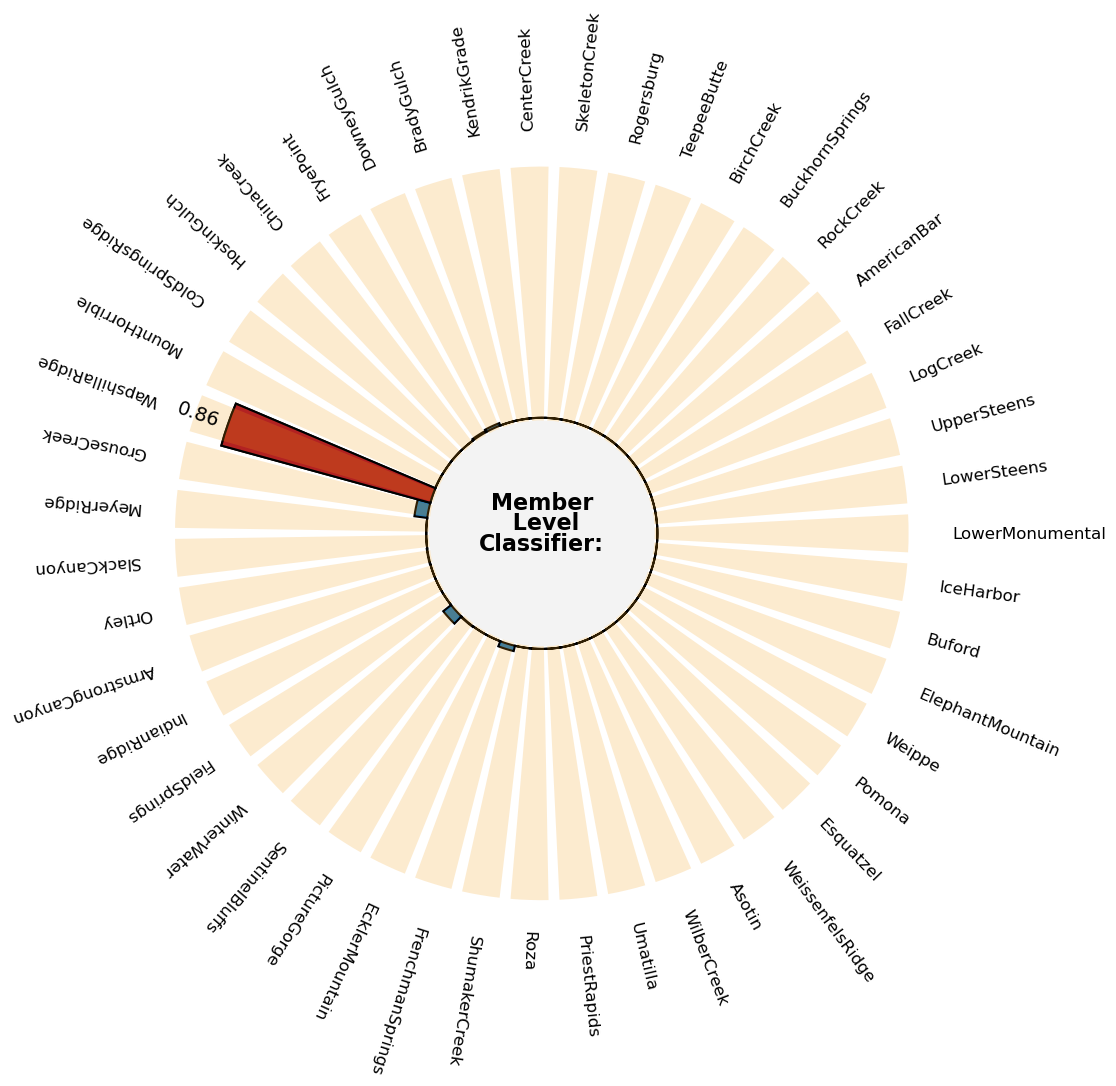

In [287]:
#single panel plot for one sample
fig=plt.figure(figsize=(10,10))

    # plot polar axis
ax = plt.subplot(111, polar=True)

#sample = df['Sample'][n]
centerlabel="Member\n Level\nClassifier:\n"  
classlabels = CRB_class_labels.Member

geoplots.plot_single_classification(data,classlabels,fig,ax,centerlabel,12,lowerLimit)

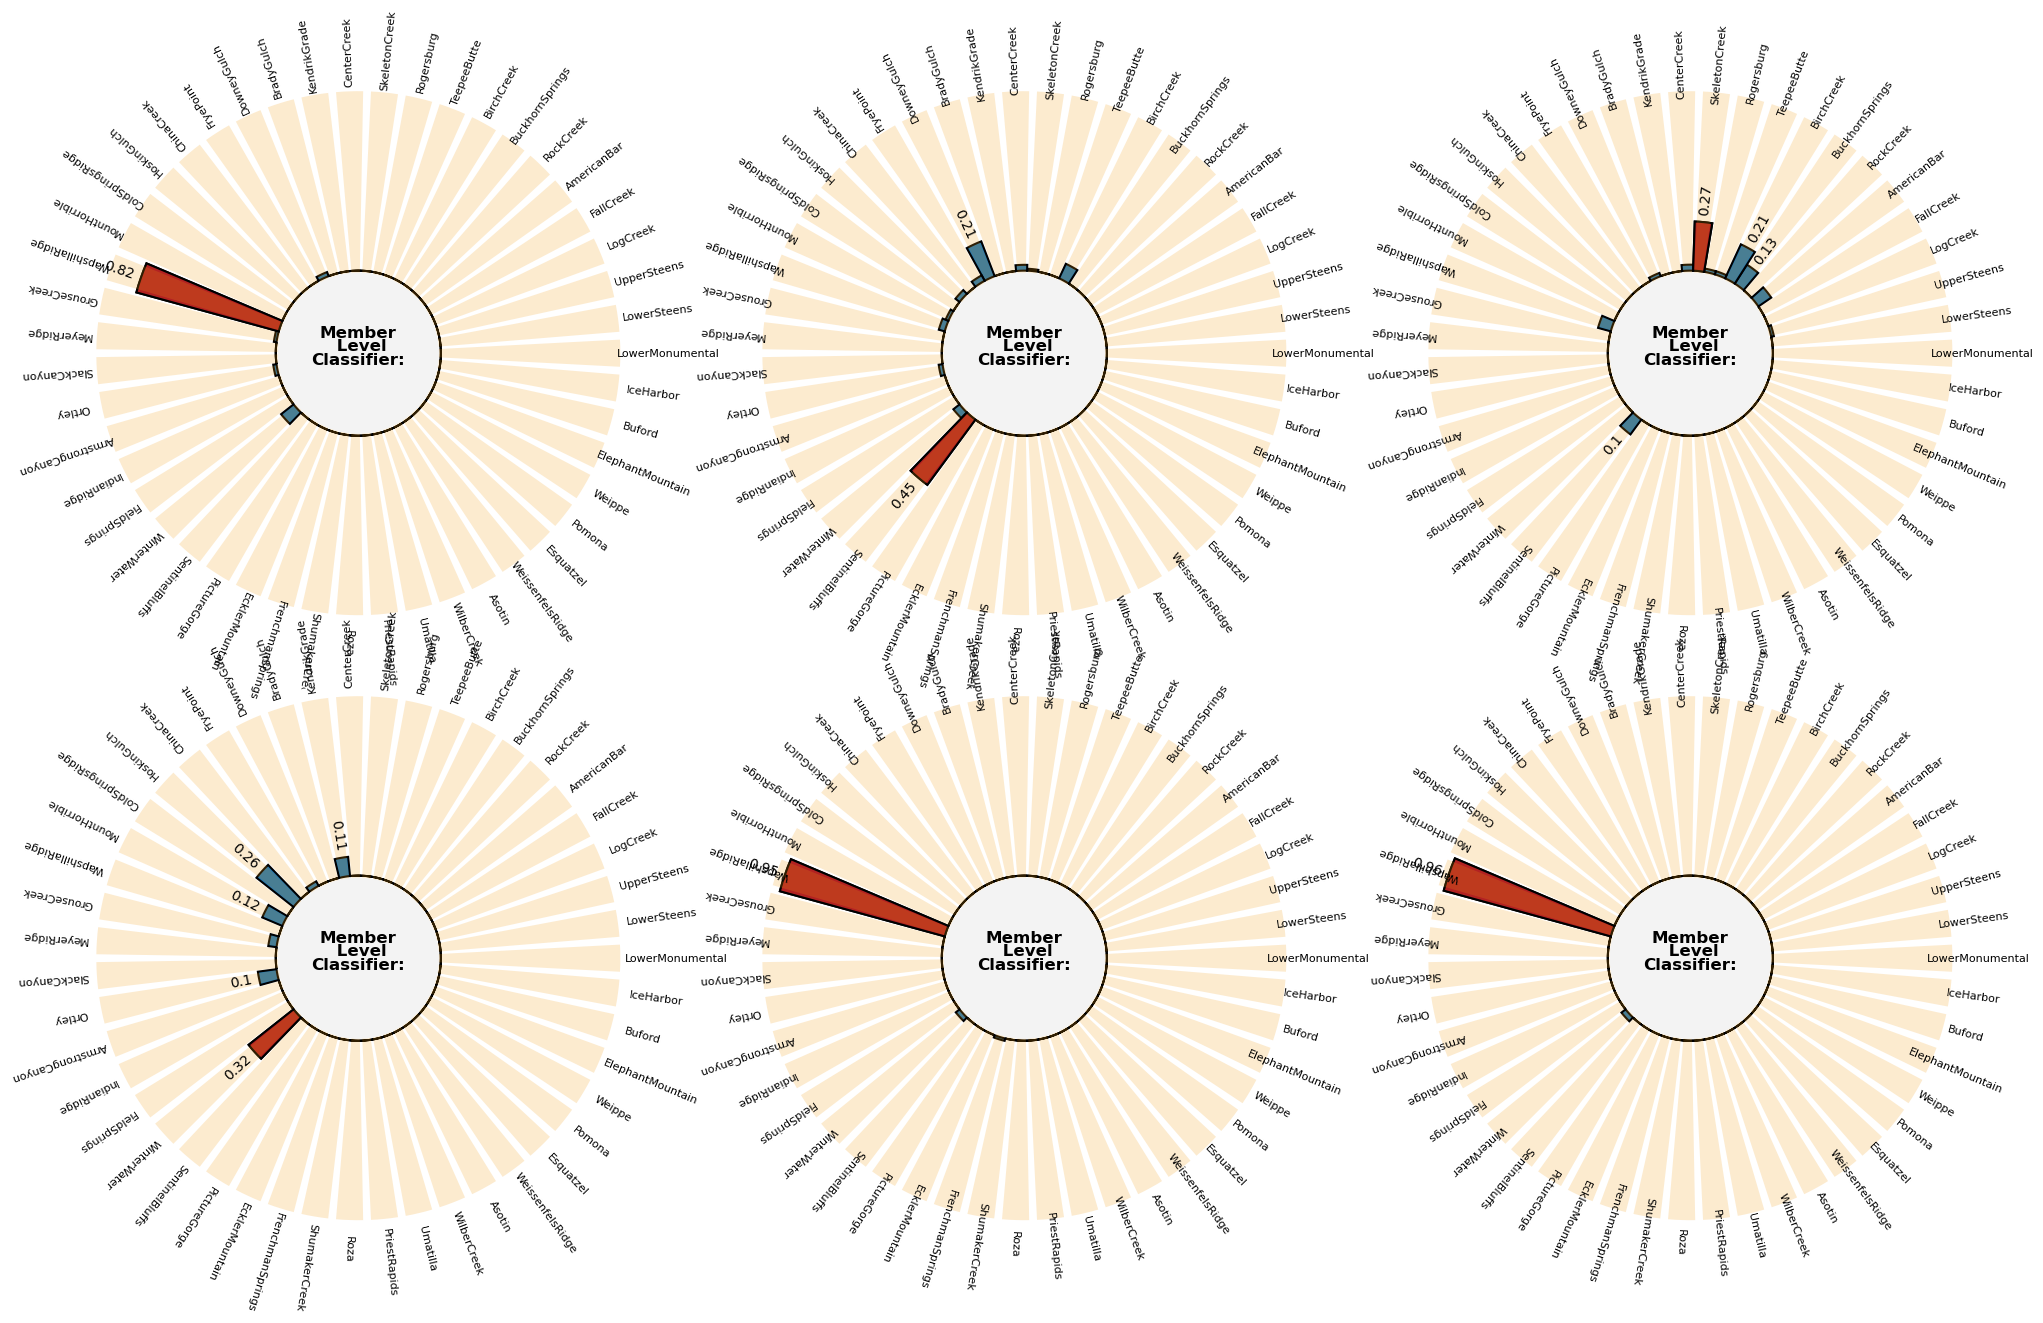

In [288]:
#multiple panel plot
nrow = 2
ncol = 3
fig, axes = plt.subplots(nrow, ncol, figsize=(25, 15), subplot_kw={"projection": "polar"})
fig.patch.set_facecolor("white")

# Define the slices used to iterate through 'axes'.
# It iterates in a rowwise manner.
# It starts in the first row, and iterates over all the columns of that row
# from left to right, then it goes to the next row and does the same.
SLICES = [(i, j) for i in range(nrow) for j in range(ncol)]

#generate list of indices to call from our dataframe of classified samples
#total length needs to be equal to or greater than nrow*ncol
lower=20
upper=44
nidx = [i for i in range(lower,upper)]

for slice_ in SLICES:
    # Select axis
    ii = (slice_[1]+1) + ncol*slice_[0]
    
    ax = axes[slice_[0],slice_[1]]
    
    # Select indexes corresponding to the passwords in this category
    #test dataset
    n=nidx[ii-1]
    
    data = np.array(df.iloc[n,:].values)

    # Set the coordinates limits
    #upperLimit = 1
    lowerLimit = .01

    #we will set any value less than 'lowerlimit' to zero for ease in visualization. 
    data[data<lowerLimit]=0
    
    #sample number label
    centerlabel="Member\n Level\nClassifier:\n"  
    classlabels = CRB_class_labels.Member
    
    geoplots.plot_single_classification(data,classlabels,fig,ax,centerlabel,8,lowerLimit)
       
# Adjust space between subplots.
# 'wspace=0' leaves no horizontal space between subplots.
# 'hspace=0' leaves no vertical space between subplots.
fig.subplots_adjust(wspace=0.1, hspace=0.1)

## Plot up the distribution of classifications for many samples

In [358]:
#first extract the highest probability for each sample
print(df.shape[0])
maxprob = []#np.empty([df.shape[0]])
matchedprob = []
classmax = []#np.empty([df.shape[0]])
classmatched = []
secondlargest = []
secondlargestclass = []
thirdlargest = []
thirdlargestclass = []

maxprob_nm = []
class_nm = []


for i in range(0,df.shape[0]):
    
    data = np.array(df.iloc[i,:].values)

    maxprobb = np.amax(data) #most likely classification, above threshold
    idx = np.argmax(data) #where in the array this occurs   
    
    classthresh = 0.85 #threshold for match
    nthresh = 0.01 #threshold probability to consider 
    
    datasort = np.abs(np.sort(-data)) #sort from largest to smallest
    sorted_indices = np.argsort(-data)
    
    if np.amax(data)>classthresh:
        match = np.amax(data) #most likely classification, above threshold
        idxmatch = np.argmax(data) #where in the array this occurs
        
        matchedprob.append(match)
        classmatched.append(idxmatch)
    else:
        match_nm = np.amax(data)
        idxmatch_nm = np.argmax(data) 
        maxprob_nm.append(match_nm)
        class_nm.append(idxmatch_nm)
        
    secondmax = np.amax(datasort[1])
    idx2 = np.amax(sorted_indices[1])
    thirdmax = np.amax(datasort[2])
    idx3 = np.amax(sorted_indices[2])

    #q90, q50 = np.percentile(data[data>nthresh], [90 ,50])
    #q3, q1 = np.percentile(data[data>nthresh], [75 ,25])
    #iqr = q3 - q1 #interquartile range of probabilities
    
#     D=(data[(data!=maxprob)&(data>nthresh)])
    
#     if D.size != 0:
        
#         std_ofnotmax = np.std(data[(data>nthresh) & (data!=maxprob)])
#         mean_ofnotmax = np.mean(data[(data>nthresh) & (data!=maxprob)])
#         #2nd highest prob
#         max_ofnotmax = np.amax(data[(data>nthresh) & (data!=maxprob)])
#         #3rd highest prob
#         thirdmax = np.amax(data[(data<max_ofnotmax)])
        
#         idx2 = np.argmax(np.abs(data-max_ofnotmax))
#         idx3 = np.argmax(np.abs(data-thirdmax))
#     else:
#         std_ofnotmax = 0;
#         mean_ofnotmax = 0;
        
    maxprob.append(maxprobb)
    classmax.append(idx)


    secondlargest.append(secondmax)
    secondlargestclass.append(idx2)
    thirdlargest.append(thirdmax)
    thirdlargestclass.append(idx3)

print(len(maxprob),len(matchedprob))

1570
1570 688


In [371]:
#now plot up distributions 
#histmax, bin_edgesmax = np.histogram(classmax,bins=len(GRBname))

maxmean=[]
max_nm_mean=[]
firstmean = []
secmean = []
thirdmean = []
histmax=[]
histfirst=[]
histsecond=[]
histthird=[]
hist_nm = []

#now compute the stats of probability per class
for jj in range(0,len(classlabels)):
    
    maxsub = geofctns.find(classmatched,matchedprob,jj)#(classmax,maxdat,jj)
    maxnm = geofctns.find(class_nm,maxprob_nm,jj)
    
    first = geofctns.find(classmax,maxprob,jj)
    second = geofctns.find(secondlargestclass,secondlargest,jj)
    third = geofctns.find(thirdlargestclass,thirdlargest,jj)
    
    #max_nmsub = geofctns.find(classmax,mean_nm,jj) 
    histmx = geofctns.find(classmatched,[],jj)
    
    histmx_nm = geofctns.find(class_nm,[],jj)
    histfrst = geofctns.find(classmax,[],jj)
    histsec = geofctns.find(secondlargestclass,[],jj)
    histthrd = geofctns.find(thirdlargestclass,[],jj)
    
    if len(maxsub) > 0:   
        histmax.append(len(histmx))
        maxmean.append(np.mean(maxsub))
        max_nm_mean.append(np.mean(maxnm))
    else:
        histmax.append(0)
        maxmean.append(0)
        max_nm_mean.append(0)
    if len(first) > 0:
        histfirst.append(len(histfrst))
        firstmean.append(np.median(first))
    else:
        histfirst.append(0)
        firstmean.append(0)
    if len(second) > 0:
        histsec.append(len(histsec))
        secmean.append(np.median(second))
    else:
        histsec.append(0)
        secmean.append(0)
    if len(third) > 0:
        histthird.append(len(histthrd))
        thirdmean.append(np.median(third))
    else:
        histthird.append(0)
        thirdmean.append(0)
        
        # histfirst.append(0)        
        # histsecond.append(len(histsec))
        # histthird.append(len(histthrd))
        
        #histmax.append(len(histmx))
        maxmean.append(np.mean(maxsub))
        #max_nm_mean.append(np.mean(max_nmsub))
    # else:
    #     histmax.append(0)
    #     histsecond.append(0)
    #     histthird.append(0)
    #     maxmean.append(0)
    #     #max_nm_mean.append(0)

print(histmax)

print(firstmean)
print(np.shape(histmax),np.shape(y))

[3, 1, 1, 2, 9, 56, 5, 4, 2, 0, 1, 6, 23, 0, 0, 0, 7, 0, 0, 0, 126, 0, 68, 0, 0, 0, 0, 30, 11, 167, 10, 14, 9, 8, 0, 32, 29, 3, 25, 7, 0, 3, 4, 4, 3, 12, 3]
[0.47031767308322675, 0.4167590038703856, 0.5941191846779303, 0.8769649978152863, 0.8161142730299236, 0.9703939586575598, 0.4938496571536973, 0.46908981256602794, 0.6261084067061808, 0.4394184878212824, 0.4440006651285684, 0.5673896812103301, 0.9026194690069006, 0, 0.3197039637101014, 0, 0.6743597434860175, 0, 0.43789415646702856, 0.5355482052743055, 0.80788155962889, 0.43833737211570856, 0.9317733471925158, 0.3885540282693495, 0.5060023905317775, 0.5505348939013583, 0, 0.9834095743150506, 0.5955319339469567, 0.8255174994732148, 0.8039024349082011, 0.9743842855199094, 0.6571184818257324, 0.9810486219040854, 0.60596805245121, 0.8764020037036861, 0.9999843511298476, 0.995455500714086, 0.9108445962801357, 0.9646019140833086, 0.6155874804425197, 0.7416673400943179, 0.9989396653874828, 0.6874212166790634, 0.8929584461982917, 0.998553571

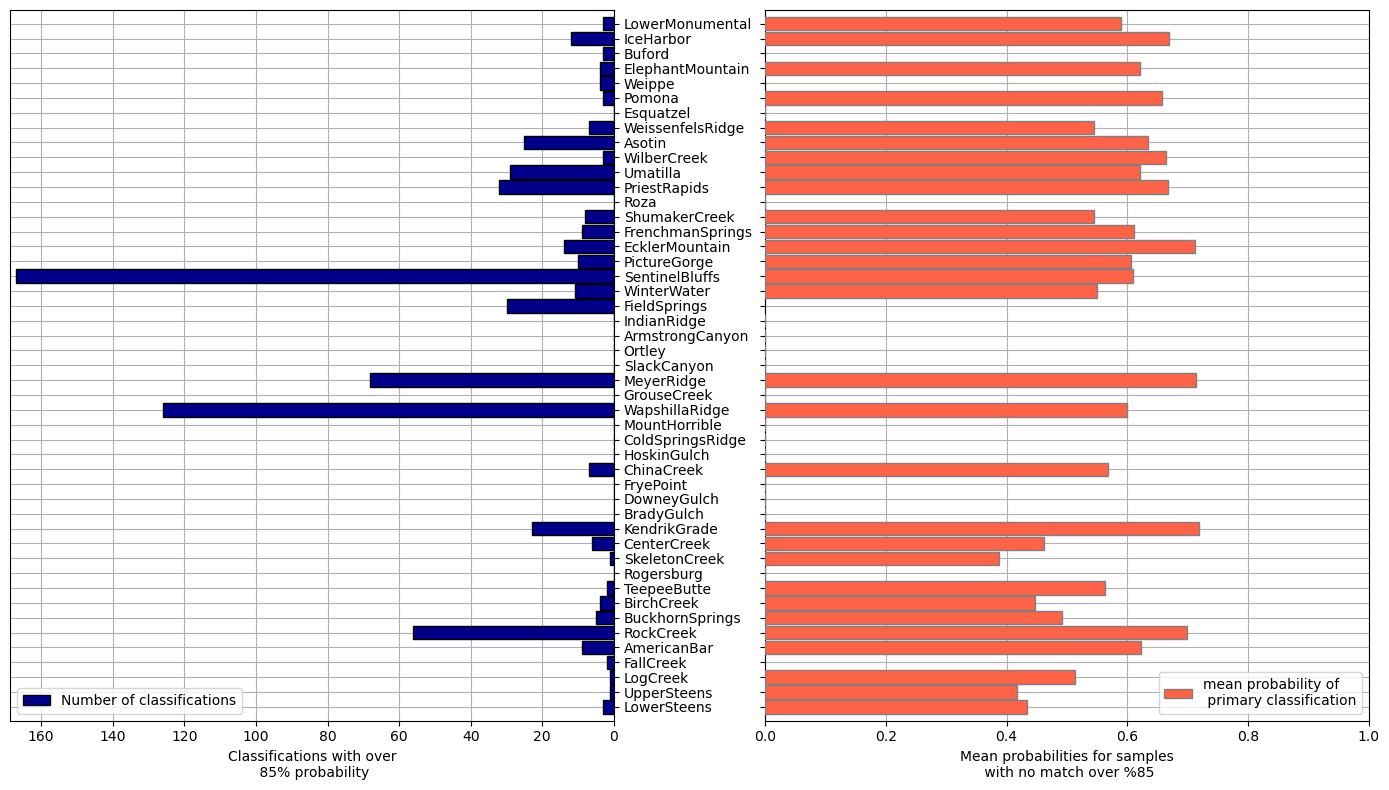

In [372]:
y = np.arange(np.array(histmax).size)

Leg = ['mean(max\n probabilities in class)','mean(non-max\n probabilities in class)']

fig, axes = plt.subplots(ncols=2, sharey=True,figsize=(14, 8))
axes[0].barh(y, histmax,0.9, align='center', color='darkblue', zorder=10, edgecolor="black",label='Number of classifications')
axes[0].set(xlabel='Classifications with over\n 85% probability')
axes[0].legend(loc='lower left')

axes[1].barh(y, max_nm_mean,0.9, align='center', color='tomato', zorder=10,edgecolor="gray",label='mean probability of\n primary classification')
#axes[1].plot(max_nm_mean,y,'k--',zorder=10,label='mean probability of\n other possible categories')
axes[1].set(xlabel='Mean probabilities for samples\n with no match over %85')
axes[1].legend(loc='lower right')

axes[1].set_xlim([0 ,1])

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=classlabels)
axes[0].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(.01)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
#plt.show()
#fig.savefig('Classification_Distribution.png')

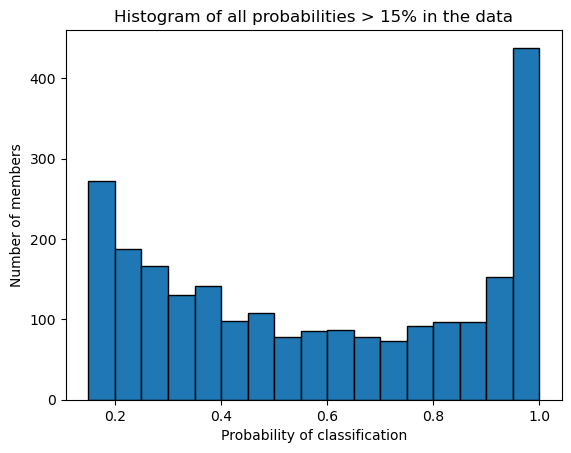

In [393]:
# Plot histogram along the x-axis (first column)
DD = df.values[df.values>.15]

plt.hist(DD,bins = np.arange( min( DD )  , 1.01 , .05 ) , edgecolor="k" )
plt.xlabel('Probability of classification')
plt.ylabel('Number of members')
plt.title("Histogram of all probabilities > 15% in the data")
plt.show()


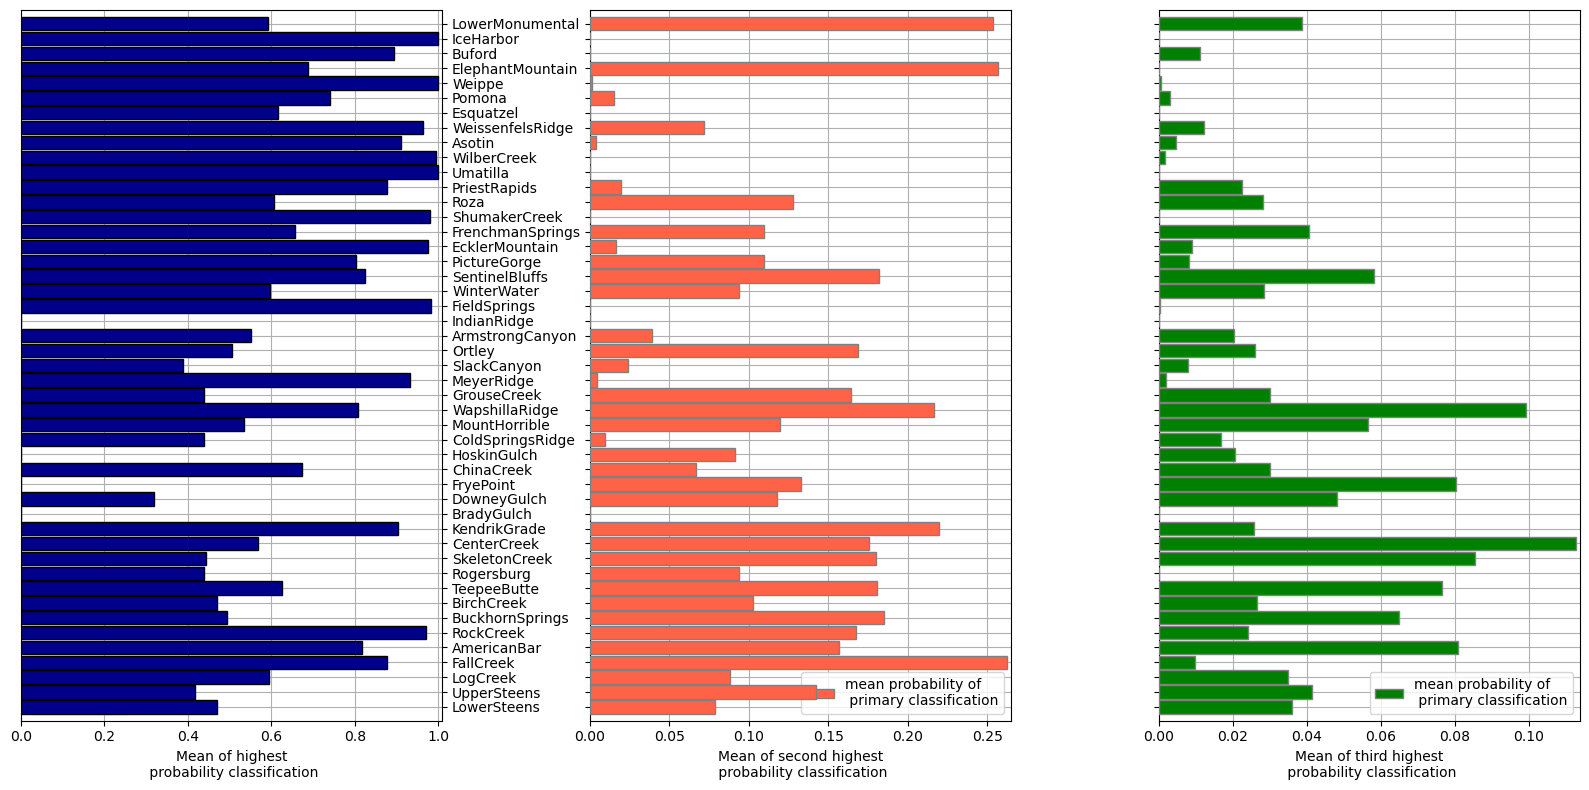

In [375]:
y = np.arange(np.array(firstmean).size)

fig, axes = plt.subplots(ncols=3, sharey=True,figsize=(16, 8))
axes[0].barh(y, firstmean,0.9, align='center', color='darkblue', zorder=10, edgecolor="black",label='Highest')
axes[0].set(xlabel='Mean of highest\n probability classification')
axes[0].legend(loc='lower left')

axes[1].barh(y, secmean,0.9, align='center', color='tomato', zorder=10,edgecolor="gray",label='mean probability of\n primary classification')
#axes[1].plot(max_nm_mean,y,'k--',zorder=10,label='mean probability of\n other possible categories')
axes[1].set(xlabel='Mean of second highest\n probability classification')
axes[1].legend(loc='lower right')

axes[2].barh(y, thirdmean,0.9, align='center', color='green', zorder=10,edgecolor="gray",label='mean probability of\n primary classification')
#axes[2].plot(max_nm_mean,y,'k--',zorder=10,label='mean probability of\n other possible categories')
axes[2].set(xlabel='Mean of third highest\n probability classification')
axes[2].legend(loc='lower right')


#axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=classlabels)
axes[0].yaxis.tick_right()

axes[2].set(yticks=y, yticklabels=classlabels)
#axes[1].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(.01)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.35)